In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

206


<IPython.core.display.Javascript object>


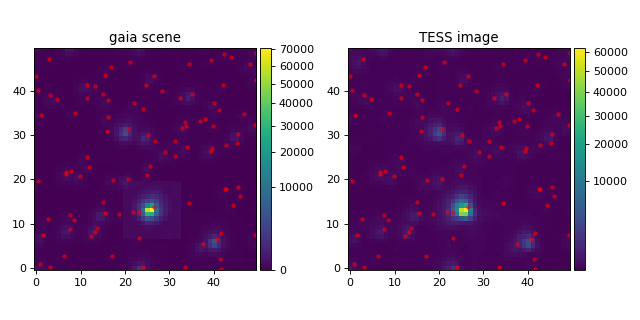

In [16]:
# single star
ra =  95.4586
dec = -51.2377
# SN2018fhw
ra = 64.5261250     
dec = -63.6150694
# SN2019esa
#ra = 118.7537042
#dec = -76.4119750 
# SN2020fqv
ra = 189.1385827     
dec = 11.2316599

# GRB 
ra = 30.26933 
dec = 24.50988

syn = sd.Catalog_scene(ra,dec,50,Maglim= 18, Sector=17, Catalog='gaia',Interpolate=False,Plot=True)#,Save='PS1_catalog_scene.pdf')
sources = syn['sources']
tpf = syn['tpf']
cat = syn['catalog']

In [157]:
bkg = np.ones_like(scene[0])
for s in scene:
    bkg = bkg * (s <= 5)

<IPython.core.display.Javascript object>


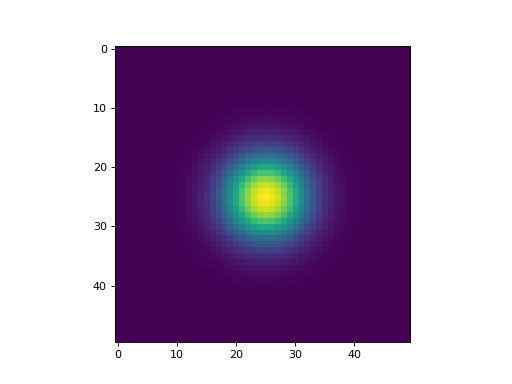

In [229]:
plt.figure()
plt.imshow(bkg,origin='lower')

In [190]:
from scipy.ndimage.filters import gaussian_filter

def Scene_bkg_estimate(Scene,tpf,Custom_mask = None,Limit = 5,Smoothing=5):
    """
    Determine the sky background of the real image by using the Scene.
    This works well for known surces, but wont work for random searches.
    Finds all sky pixels based off 'Limit' then interpolates the sky background 
    for the sources and masked areas. Workes well for large areas.

    -------
    Inputs-
    -------
        Scene 			array 	Array of images containing a source each 
        tpf 			class 	Target pixel file lighkurve class
        Custom_mask 	array 	Manual mask to ensure science target is masked
        Limit 			float 	Counts limit for determining sky pixels

    --------
    Outputs-
    --------
        bkg 			array 	Array with shape tpf.flux containing background 
                                flux for each frame. 
    """

    mask = np.ones_like(Scene[0])
    for s in Scene:
        mask = mask * (s <= Limit)
    if type(Custom_mask) != type(None):
        print('additional mask')
        mask = mask * Custom_mask
    bkg = np.zeros_like(tpf.flux)
    x = np.arange(0, mask.shape[1])
    y = np.arange(0, mask.shape[0])
    #mask invalid values
    for i in range(len(tpf.flux)):
        arr = tpf.flux[i]
        arr[mask==0] = np.nan
        arr = np.ma.masked_invalid(arr)
        xx, yy = np.meshgrid(x, y)
        #get only the valid values
        x1 = xx[~arr.mask]
        y1 = yy[~arr.mask]
        newarr = arr[~arr.mask]

        estimate = interpolate.griddata((x1, y1), newarr.ravel(),
                                  (xx, yy),method='linear')
        nans = np.where(np.isnan(estimate))
        # need a better way of doing this
        estimate[nans] = np.nanmedian(estimate)
        if Smoothing > 0:
            estimate = gaussian_filter(estimate,Smoothing,mode='constant')
        bkg[i] = estimate

    return bkg

<IPython.core.display.Javascript object>


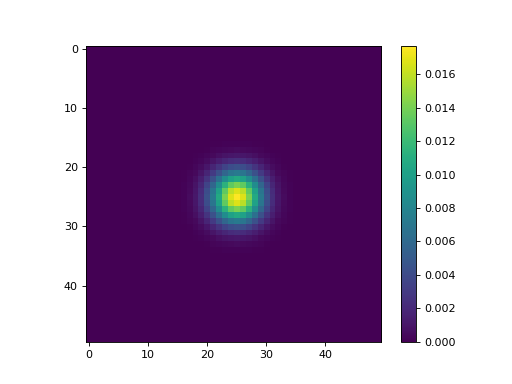

In [234]:
eh = np.zeros_like(clean[0])
eh[25,25] = 1 
eh = gaussian_filter(eh,3,mode='constant')
plt.figure()
plt.imshow(eh)
plt.colorbar()

In [226]:
cus = np.ones_like(tpf.flux[0])
cus[20:29,20:29] = 0
cus[14:21,30:38] = 0
none = Scene_bkg_estimate(scene,tpf,Custom_mask=cus,Smoothing=0)
some = Scene_bkg_estimate(scene,tpf,Custom_mask=cus,Smoothing=3)
much = Scene_bkg_estimate(scene,tpf,Custom_mask=cus,Smoothing=5)
clean = tpf.flux-none
clean2 = tpf.flux-some
clean3 = tpf.flux-much

additional mask
additional mask
additional mask


<IPython.core.display.Javascript object>


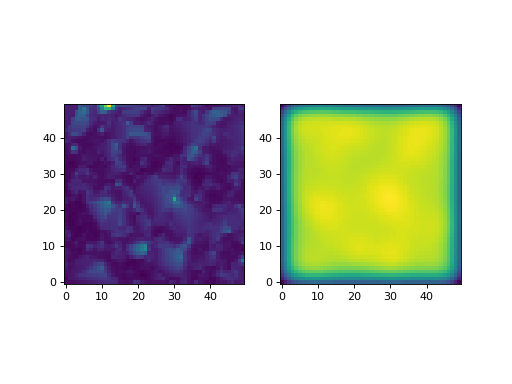

In [228]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(none[1000],origin='lower')
plt.subplot(1,2,2)
plt.imshow(some[100],origin='lower')

<IPython.core.display.Javascript object>


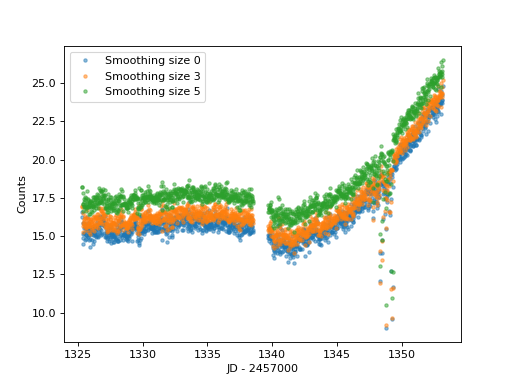

In [227]:

plt.figure()
plt.plot(tpf.astropy_time.jd-2457000,clean[:,25,25],'.',alpha=0.5,label='Smoothing size 0')
plt.plot(tpf.astropy_time.jd-2457000,clean2[:,25,25],'.',alpha=0.5,label='Smoothing size 3')
plt.plot(tpf.astropy_time.jd-2457000,clean3[:,25,25],'.',alpha=0.5,label='Smoothing size 5')
#plt.plot(clean[:,26,26])
#plt.plot(clean[:,24,24]-np.nanmedian(clean[:100,24,24]),'.')
#plt.xlim(1772.6,1773)
#plt.ylim(-1,40)
plt.ylabel('Counts')
plt.xlabel('JD - 2457000')
plt.legend()
plt.savefig('Smoothing_0_3_5.pdf')

In [238]:
tpf.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'STScI/MAST'         / institution responsible for creating this file 
DATE    = '2018-12-05'         / file creation date.                            
TSTART  =    1325.313100604524 / observation start time in TJD                  
TSTOP   =    1353.167256127407 / observation stop time in TJD                   
DATE-OBS= '2018-07-25T19:29:

# GRB test

In [8]:
from matplotlib import gridspec
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator


382

In [17]:
cus = np.ones_like(tpf.flux[0])
cus[20:29,20:29] = 0
bkg = sd.Scene_bkg_estimate(sources,tpf,Limit=.3,interp_method='cubic',Custom_mask=cus)
sub = tpf.flux-bkg


additional mask


../scenes/syndiff.py:633: RuntimeWarning: invalid value encountered in less
  large = masked < (med + sigma*std)[:,np.newaxis,np.newaxis]


<IPython.core.display.Javascript object>


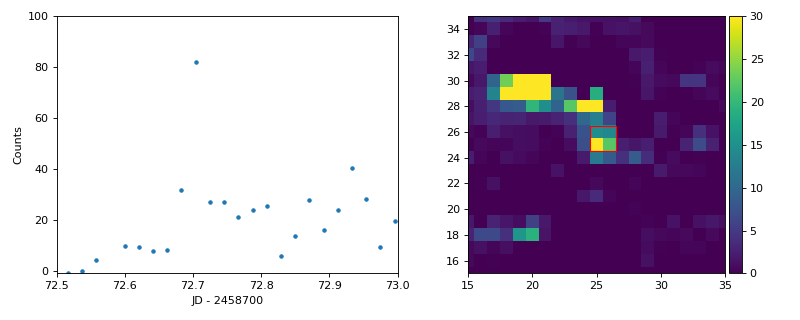

In [19]:
ref = np.nanmedian(sub[:100,25:27,25:27],axis=(0))
lc = np.nansum(sub[:,25:27,25:27]-ref,axis=(1,2))
ind = np.where(tpf.astropy_time.jd-2457000 >= 1772.7)[0][0]
#sub[sub<0] = np.nan
plt.figure(figsize=(10,4))
#plt.plot(tpf.astropy_time.jd-2457000,tpf.flux[:,26,26]/np.nanmax(tpf.flux[:,26,26]),'.')
#plt.plot(test[:,24,24])

plt.subplot(1,2,1)
#plt.plot(tpf.astropy_time.jd-2458700,sub[:,25,25]-np.nanmedian(sub[:100,25,25]),'.')
plt.plot(tpf.astropy_time.jd-2458700,lc-np.nanmedian(lc[:100]),'.')
plt.xlim(72.5,73)
plt.ylim(-1,100)
plt.ylabel('Counts')
plt.xlabel('JD - 2458700')
plt.subplot(1,2,2)
im = plt.imshow(sub[ind]-sub[10],origin='lower',vmin=0,vmax=30)
plt.ylim(15,35)
plt.xlim(15,35)
rect = patches.Rectangle((25-.5,25-.5),2,2,linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.colorbar(im, cax=cax)

plt.tight_layout()
#plt.savefig('grb_sndiff_bkd.pdf')

In [49]:
ind =np.where(1772.7 <= tpf.astropy_time.jd-2457000)[0][0]

<IPython.core.display.Javascript object>


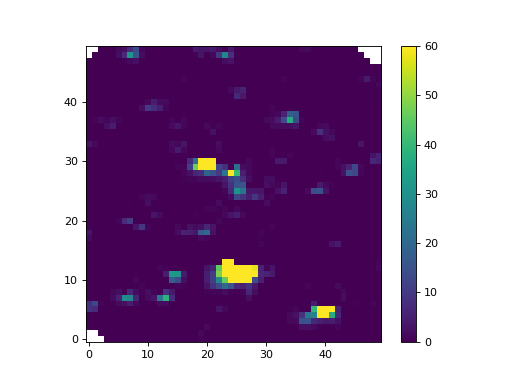

In [65]:
plt.figure()
plt.imshow(sub[ind]-sub[10],origin='lower',vmin=0,vmax=60)
plt.colorbar()

<IPython.core.display.Javascript object>


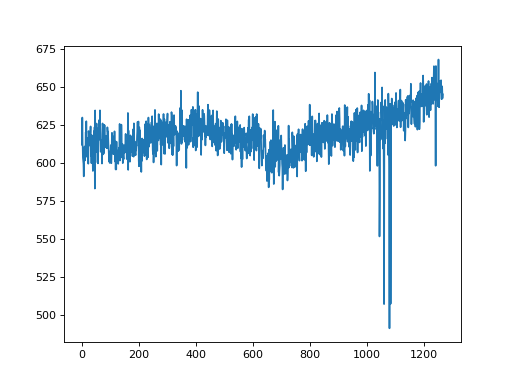

<IPython.core.display.Javascript object>


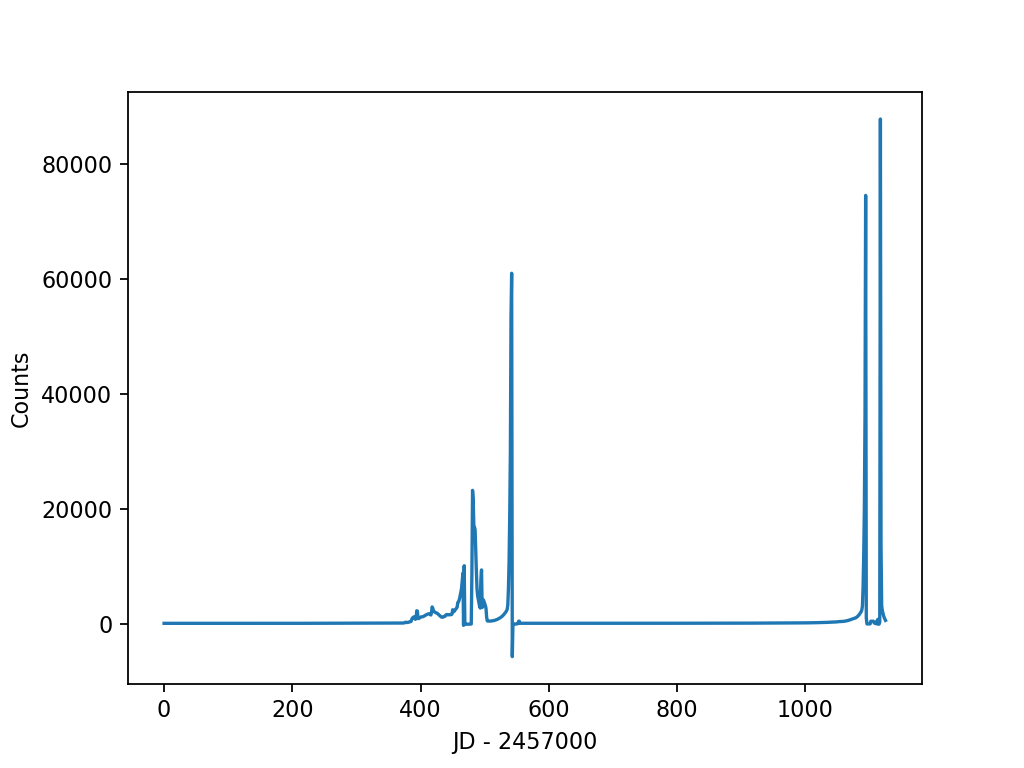

Text(0.5, 0, 'JD - 2457000')

In [128]:
plt.figure()
#plt.plot(tpf.astropy_time.jd-2457000,tpf.flux[:,26,26]/np.nanmax(tpf.flux[:,26,26]),'.')
plt.plot(test[:,25,25])
#plt.plot(sub[:,25,25]-np.nanmedian(sub[:100,25,25]),'.')
#plt.xlim(1772.6,1773)
#plt.ylim(-1,40)
plt.ylabel('Counts')
plt.xlabel('JD - 2457000')

<IPython.core.display.Javascript object>


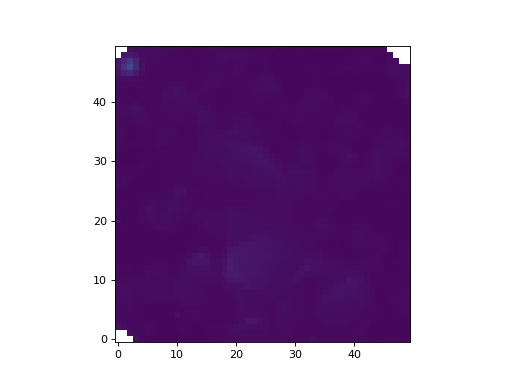

In [111]:
fig, ax = plt.subplots()

im = plt.imshow(test[0],origin='lower',vmin=100,vmax=1000)

In [112]:
im.set_data(test[1])

<IPython.core.display.Javascript object>


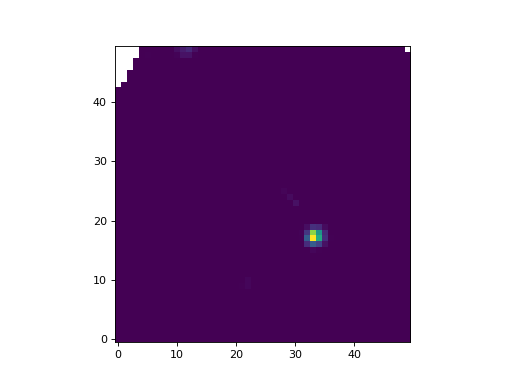

In [154]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from astropy.visualization import (SqrtStretch, ImageNormalize)

fig, ax = plt.subplots()
norm = ImageNormalize(vmin=np.nanmin(test), 
                      vmax=np.nanmax(test), stretch=SqrtStretch())
im = plt.imshow(test[0],origin='lower',vmin=100,vmax=500)


def init():  # only required for blitting to give a clean slate.
    im.set_data(np.nan * np.zeros_like(test[0]))
    return im,


def animate(i):
    im.set_data(test[i])
    return im,


anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(test), interval=20, blit=True)
anim.save("test_movie.mp4")

In [121]:
anim.save("test_movie.mp4")

# Why fqv background rubbish?

In [197]:
scene = np.nansum(sources,axis=0)

mask = sc < 0.5

<IPython.core.display.Javascript object>


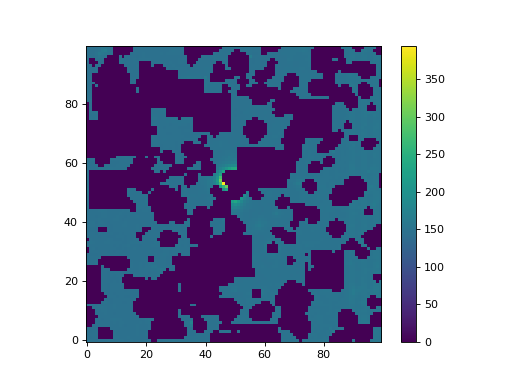

In [159]:
plt.figure()
plt.imshow(mask*tpf.flux[400],origin='')
plt.colorbar()

looks like the galaxy is spilling over

In [21]:
from astropy.stats import sigma_clip

In [160]:
thing = mask*tpf.flux[400]
thing[thing==0] = np.nan
clip = sigma_clip(thing,sigma=3)
mask = ~clip.mask

<IPython.core.display.Javascript object>


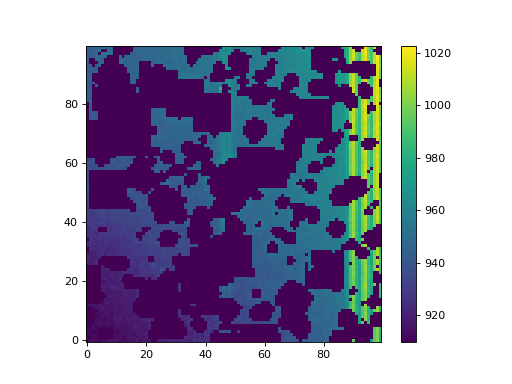

In [161]:
plt.figure()
plt.imshow(~clip.mask*tpf.flux[800],origin='',vmin=910)
plt.colorbar()

looks like sigma clipping is needed

In [156]:
Guess = True
Round2 = True
Smooth = False
bkg = np.zeros_like(tpf.flux)
x = np.arange(0, mask.shape[1])
y = np.arange(0, mask.shape[0])
#mask invalid values
for i in range(len(tpf.flux)):
    arr = tpf.flux[i]
    arr[mask==0] = np.nan
    arr = np.ma.masked_invalid(arr)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~arr.mask]
    y1 = yy[~arr.mask]
    newarr = arr[~arr.mask]

    estimate = sd.interpolate.griddata((x1, y1), newarr.ravel(),
                              (xx, yy),method='nearest')
    if Guess:
        estimate[np.isnan(estimate)] = np.nanmedian(estimate)
        
    if Round2:
        m = ~sigma_clip(estimate).mask
        arr = estimate
        arr[m==0] = np.nan
        arr = np.ma.masked_invalid(arr)
        xx, yy = np.meshgrid(x, y)
        #get only the valid values
        x1 = xx[~arr.mask]
        y1 = yy[~arr.mask]
        newarr = arr[~arr.mask]

        estimate = sd.interpolate.griddata((x1, y1), newarr.ravel(),
                                  (xx, yy),method='nearest')
        if Guess:
            estimate[np.isnan(estimate)] = np.nanmedian(estimate)
    
    if Smooth:
        estimate = sgolay2d(estimate,31,3)
        
    bkg[i] = estimate

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of t

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<IPython.core.display.Javascript object>


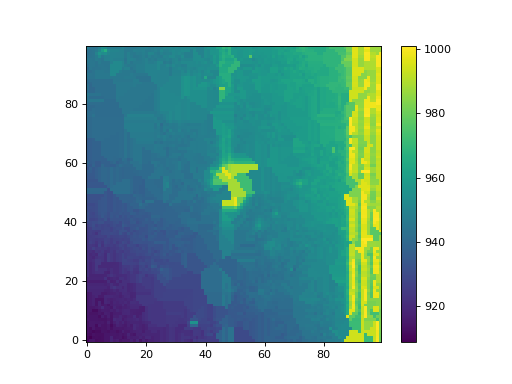

In [157]:
plt.figure()
plt.imshow(bkg[800],origin='')
plt.colorbar()

Clipping doesnt solve the problem. It looks like griddata enters an feedback loop

In [138]:
eh = bkg[400]
m = ~sigma_clip(eh).mask

<IPython.core.display.Javascript object>


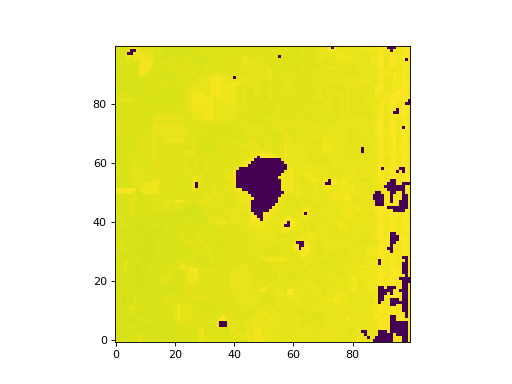

In [139]:
plt.figure()
plt.imshow(m*bkg[400],origin='')

In [140]:
x = np.arange(0, mask.shape[1])
y = np.arange(0, mask.shape[0])
#mask invalid values
for i in range(1):#len(tpf.flux)):
    i = 400
    arr = bkg[i]
    arr[m==0] = np.nan
    arr = np.ma.masked_invalid(arr)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~arr.mask]
    y1 = yy[~arr.mask]
    newarr = arr[~arr.mask]

    estimate = sd.interpolate.griddata((x1, y1), newarr.ravel(),
                              (xx, yy),method='nearest')
    if Guess:
        estimate[np.isnan(estimate)] = np.nanmedian(estimate)
    bkg[i] = estimate
    

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<IPython.core.display.Javascript object>


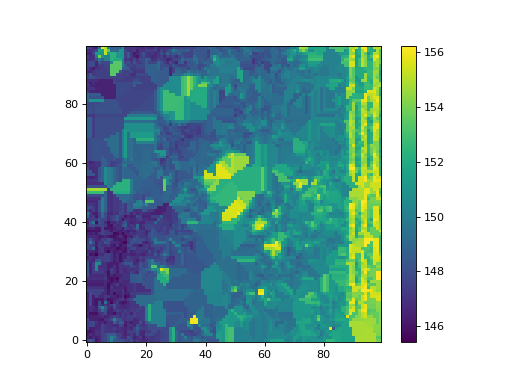

In [141]:
plt.figure()
plt.imshow(bkg[400],origin='')
plt.colorbar()

In [299]:
import scipy
def sgolay2d ( z, window_size, order, derivative=None):
    """
    taken from https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')  

In [126]:
test = sgolay2d(bkg[400],31,3)

<IPython.core.display.Javascript object>


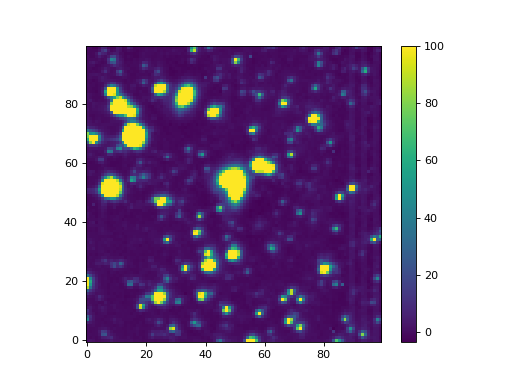

In [129]:
plt.figure()
plt.imshow(tpf.flux[400]-test,origin='',vmax=100)
plt.colorbar()

# neighbour matching

In [80]:
from scipy.interpolate import interp1d

In [86]:
test = ~clip.mask*tpf.flux[800]
test[test==0] = np.nan

x = np.arange(0,100)
y = test[:,50]
ind = np.isfinite(y)
fun = interp1d(x[ind],y[ind],bounds_error=False,fill_value=np.nan)
interpo = fun(x)

<IPython.core.display.Javascript object>


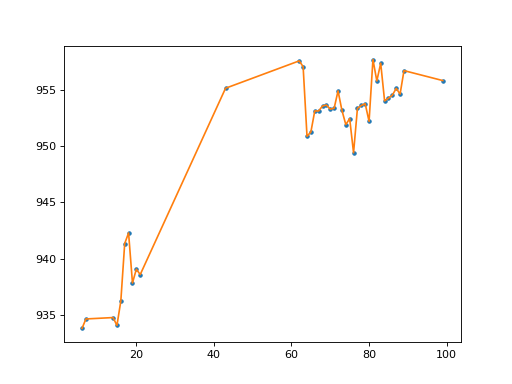

In [87]:
plt.figure()
plt.plot(y,'.')
plt.plot(interpo)

In [95]:
from scipy.interpolate import griddata

In [89]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [90]:
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

In [91]:
values.shape

(1000,)

In [96]:
points

array([[0.29335269, 0.72593627],
       [0.72056073, 0.21114315],
       [0.91089706, 0.05657339],
       ...,
       [0.97244467, 0.40173127],
       [0.73067922, 0.16128127],
       [0.79259932, 0.88518585]])

In [94]:
grid_x.shape

(100, 200)

In [153]:
f = tpf.flux-bkg

<IPython.core.display.Javascript object>


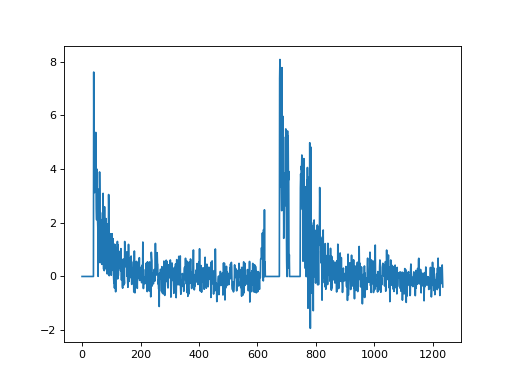

In [155]:
plt.figure()
plt.plot(f[:,10,10])

In [196]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [203]:
bkg = np.zeros_like(tpf.flux)
for i in range(1):#len(tpf.flux)):
    i = 800
    if np.nansum(tpf.flux[i]) > 0:
        thing = mask*tpf.flux[i]
        thing[thing==0] = np.nan
        clip = sigma_clip(thing,sigma=3)
        m = ~clip.mask

        ny,nx = np.where(~m)
        dy,dx = np.where(m)
        xs = np.zeros((len(nx),len(dx)))
        ys = np.zeros((len(ny),len(dy)))

        xs = xs + nx[:,np.newaxis] - dx[np.newaxis,:]
        ys = ys + ny[:,np.newaxis] - dy[np.newaxis,:]

        d = np.sqrt(xs**2 + ys**2)
        ind = np.argmin(d,axis=1)

        back = m * tpf.flux[i]
        back[ny,nx] = back[dy[ind],dx[ind]]
        bkg[i] = back

In [256]:
e = sigma_clip(tpf.flux*mask,axis=(1,2)).mask
test = convolve(~e*1,np.ones((1,3,3))) > 0
background = ~test * tpf.flux

In [267]:
masked = tpf.flux*mask
masked[masked==0] = np.nan
med = np.nanmedian(masked,axis=(1,2))
std = np.nanstd(masked,axis=(1,2))

/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [273]:
def Sig_clip_frames(tpf,mask,sigma=3,itters=5):
    masks = np.zeros_like(tpf.flux) + mask[np.newaxis,:,:]
    
    for i in range(itters):
        masked = tpf.flux * masks
        masked[masked==0] = np.nan
        med = np.nanmedian(masked,axis=(1,2))
        std = np.nanstd(masked,axis=(1,2))
        
        large = masked < (med + sigma*std)[:,np.newaxis,np.newaxis]
        masks = masks * large
        
    return masks 

In [275]:
test = Sig_clip_frames(tpf,mask)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [286]:
hmm = np.nansum(test,axis=0) > 1000

In [328]:
mask = hmm
bkg = np.zeros_like(tpf.flux)
x = np.arange(0, mask.shape[1])
y = np.arange(0, mask.shape[0])
#mask invalid values
for i in range(len(tpf.flux)):
    arr = tpf.flux[i]
    arr[mask==0] = np.nan
    arr = np.ma.masked_invalid(arr)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~arr.mask]
    y1 = yy[~arr.mask]
    newarr = arr[~arr.mask]

    estimate = sd.interpolate.griddata((x1, y1), newarr.ravel(),
                              (xx, yy),method='cubic')
    if Guess:
        estimate[np.isnan(estimate)] = np.nanmedian(estimate)
    bkg[i] = estimate

<IPython.core.display.Javascript object>


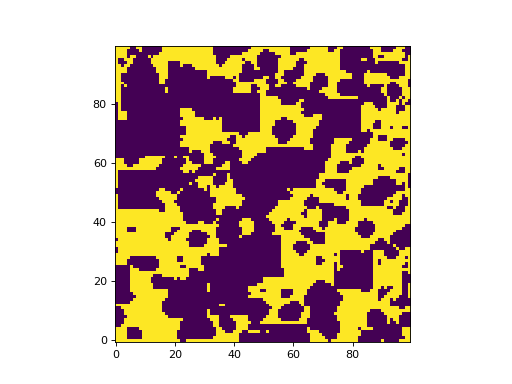

<IPython.core.display.Javascript object>


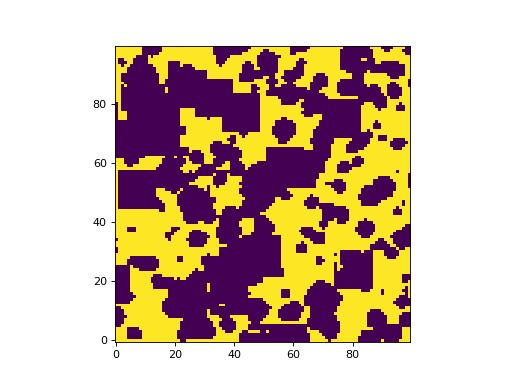

<IPython.core.display.Javascript object>


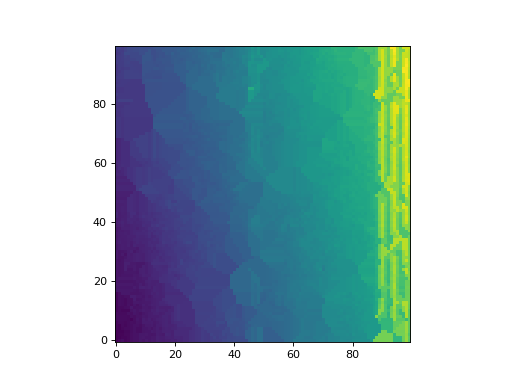

In [292]:
plt.figure()
plt.imshow(mask*1,origin='')
plt.figure()
plt.imshow(test[1000],origin='')
plt.figure()
plt.imshow(bkg[100],origin='')

<IPython.core.display.Javascript object>


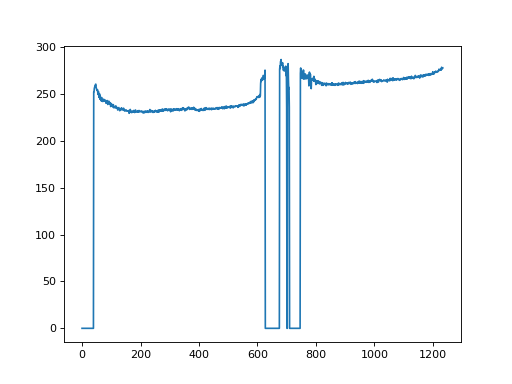

In [298]:
plt.figure()
plt.plot(tpf.flux[:,49,49] - bkg[:,49,49])

array([21, 24, 41, ..., 93, 97, 97])

In [213]:
from scipy.ndimage.filters import convolve

In [225]:
test = convolve(~e*1,np.ones((1,3,3))) > 0

In [224]:
test 

array([[[9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        ...,
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9]],

       [[9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        ...,
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9]],

       [[9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        ...,
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9]],

       ...,

       [[9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        ...,
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9]],

       [[9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        [9, 9, 9, ..., 9, 9, 9],
        ...,
        [9, 9, 9, ..., 

<IPython.core.display.Javascript object>


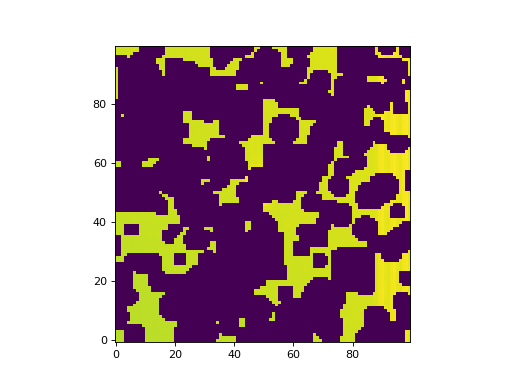

In [228]:
plt.figure()
plt.imshow(~test[800]*tpf.flux[800],origin='')

<IPython.core.display.Javascript object>


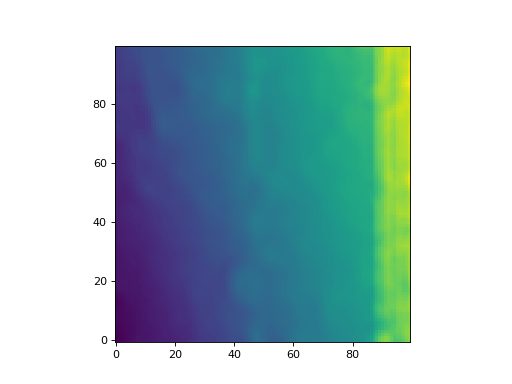

In [309]:
plt.figure()
plt.imshow(sgolay2d(bkg[100],9,2),origin='')

In [310]:
test = bkg.copy()
for i in range(len(test)):
    test[i] = sgolay2d(test[i],9,2)

In [311]:
eh = tpf.flux - test

<IPython.core.display.Javascript object>


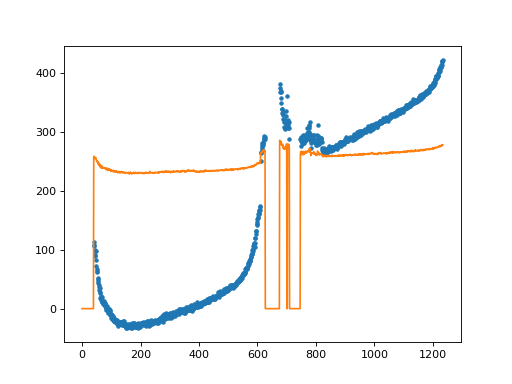

In [335]:
e = np.nansum(eh[:,50:52,49:51],axis=(1,2))
e[e==0] = np.nan
plt.figure()
#plt.plot(eh[:,50,49])
plt.plot(e-2400,'.')
plt.plot(eh[:,49,49])

<IPython.core.display.Javascript object>


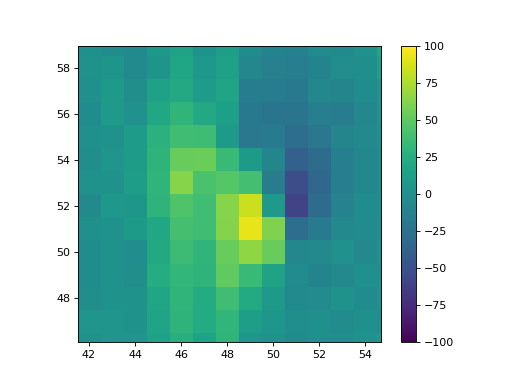

In [343]:
plt.figure()
plt.imshow(eh[695]-eh[500],vmax =100,vmin=-100,origin='')
plt.colorbar()